# 3. Teoría de la estimación
# 3.1. Función de verosimilitud

<p align="right">
Autor: Emmanuel Alcalá
<br>
<a href="https://scholar.google.com.mx/citations?hl=en&user=3URusCgAAAAJ&view_op=list_works&sortby=pubdate">Google Scholar</a>
</p>

<p align="left">
<br>
<a href="https://jealcalat.github.io/Analisis_multivariado/">Regresar a la página del curso</a>
</p>

---

**Modelos de probabilidad** ¿Cuál es la probabilidad de observar los *datos* dado los *parámetros* que conocemos?

Ej. ¿Cuán probable es que obtengamos 9 "Caras" (1) si lanzamos una moneda "justa" ( $p=0.5$ ) 10 veces? 

ver https://github.com/mebucca/cda_soc3070/blob/master/slides/class_4/class_4.Rmd

In [ ]:
dbinom(x=9,size=10,prob=0.5)

**Modelos estadísticos**  ¿Cuáles son los valores más .bold[plausibles][1].footnote[[1] Notar que no dice "más probables"!] de los *parámetros* dado los *datos* que observamos? 


Ej. Supongamos que alguien lanza 100 veces la misma moneda y registra los resultados en una base de datos. Los datos se ven así:  


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


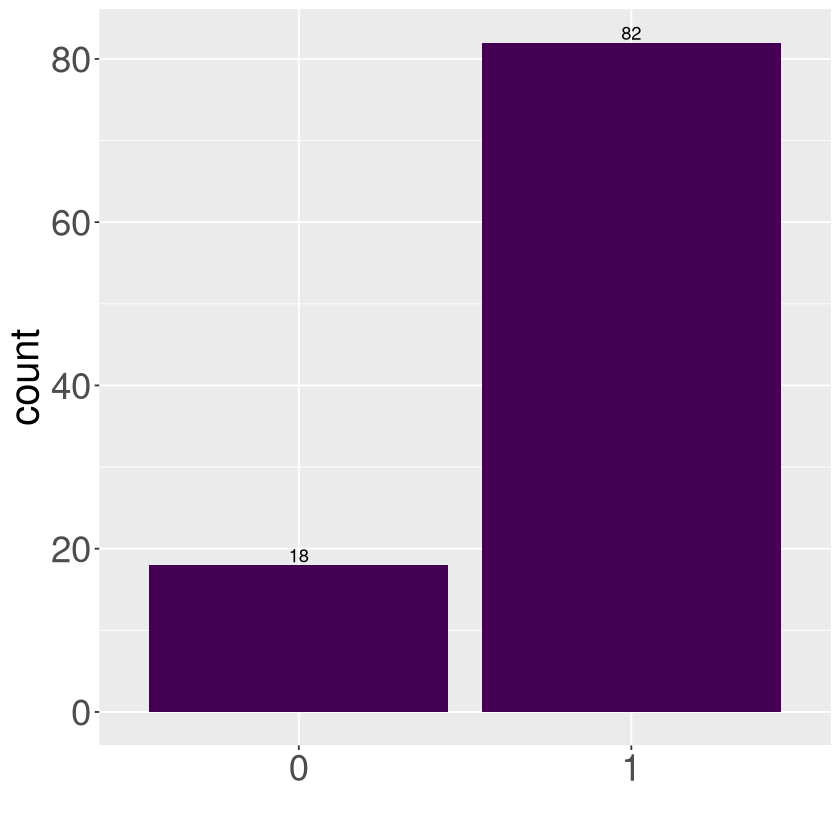

In [1]:
library("tidyverse")
set.seed(481)
data_coins <- data.frame(X = rbinom(n=100, size=1, prob=0.8))
data_coins %>% ggplot(aes(x=factor(X), fill="")) + 
    geom_bar() +
    geom_text(aes(label=..count..), stat='count', vjust=-0.2) +
    scale_fill_viridis_d() + 
    guides(fill=FALSE, color=FALSE) + labs(x="") +
    theme(axis.text.y = element_text(size = 22), axis.text.x = element_text(size = 22),
    axis.title.y = element_text(size = 24), axis.title.x = element_text(size = 24), 
    legend.text = element_text(size = 18), legend.position="bottom") 

- Lo que vemos en la izquierda son **datos**

- Datos: realización de $n$ variables aleatorias 

- Normalmente *no conocemos* la distribución de las variables

- Datos nos dan una pista sobre cuál podría ser esa distribución

- **Estadística**: aprender de los datos para .bold[*estimar*] los parámetros que los generan

## Estimación via Maximum Likelihood (MLE) 

Previamente lanzamos la misma moneda 100 veces y obtuvimos "Cara" (1) 82 veces.

 ¿Qué valor de $p$ es más plausible ("likely") que genere estos datos?

MLE es justamente la formalización de esta pregunta. Pasos:



1) Decidir sobre la distribución subyacente que genera los datos. En este caso, podemos asumir que: 

  * Cada lanzamiento $X_{1}, X_{2}, \dots X_{100} \sim \text{Bernoulli}(p)$, donde X's son $iid$ 

--

2)  Escribir una función que cuantifique la plausibilidad de diferentes valores del parámetro. Dicha función se denomina .bold[likelihood function]: 

<br>
  * $\mathcal{L}(p \mid \text{ Datos}) = \mathbb{P}(\text{ Datos : \{1,0,1,1,....0,1\}} | \text{ } p)$

<br>
--

  * $\mathcal{L}(p \mid \text{ Datos}) = \mathbb{P}(x_{1})\mathbb{P}(x_{2}) \dots \mathbb{P}(x_{100}) = p^{82}(1-p)^{18}$
